### Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Install Pytorch Geometric Temporal

In [2]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torch_geometric
!pip install torch-scatter

2.0.1+cu118
11.8


In [3]:
import torch
import numpy as np

# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### `ASLDatasetLoader` Class

The `ASLDatasetLoader` class is designed for loading and processing the ASL dataset. Given a directory, it reads sign language data from JSON files and constructs graph representations suitable for graph-based neural networks. Crucially, the class converts JSON data into PyTorch Geometric (PyG) `Data` objects comprising `x` (node features), `edge_index` (graph connectivity), and `y' (labels) attributes.

**Methods**:

- `_create_sign_to_label_map`: Generates a mapping from sign names to unique labels.

- `_read_file_data`: Reads data from a given JSON file.

- `_augment_data`: Implements data augmentation by applying random rotation, translation, and scaling to landmarks, which can enhance the model's robustness.

- `_create_graph_from_frame`: Constructs a PyG `Data` object from frame data, concentrating on hand and face landmarks. Edges are created between consecutive landmarks and between left and right hand landmarks. Additional features, like hand-to-face distances, are also computed.

- `get_dataset`: Assembles the dataset, optionally incorporating data augmentation. The function outputs a list of PyG `Data` objects ready for graph neural network processing.

In [4]:
import os
import json
from itertools import repeat
from torch_geometric.data import InMemoryDataset, Data

class ASLInMemoryDataset(InMemoryDataset):
    def __init__(self, root, augment=False, transform=None, pre_transform=None):
        self.augment = augment
        super(ASLInMemoryDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.splitext(filename)[0] for filename in os.listdir(self.raw_dir)]

    @property
    def processed_file_names(self):
        return ['processed_data.pt']

    def download(self):
        # We're using local files, so no need to implement download logic
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = []

        loader = ASLDatasetLoader(self.raw_dir)
        self._sign_to_label = loader.sign_to_label
        dataset = loader.get_dataset()

        if self.augment:
            augmented_dataset = []
            for data in dataset:
                frame_data = {
                    "landmarks": data.x[:, :2].tolist(),
                    "deltas": data.x[:, 2:4].tolist(),
                    "landmark_types": ["L" if feature > 0.5 else "R" for feature in data.x[:, -1].tolist()]
                }
                augmented_frame_data = loader._augment_data(frame_data)
                sign_name = list(loader.sign_to_label.keys())[data.y.item()]
                augmented_data = loader._create_graph_from_frame(sign_name, augmented_frame_data, {"frames": [frame_data]}, frame_data["landmark_types"])
                augmented_dataset.append(augmented_data)
            data_list.extend(augmented_dataset)
        else:
            data_list.extend(dataset)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def len(self):
        return len(self._data.y)

    def get(self, idx):
        data = Data()
        for key in self._data.keys():
            item, slices = self._data[key], self.slices[key]
            s = list(repeat(slice(None), item.dim()))
            s[self._data.__cat_dim__(key, item)] = slice(slices[idx], slices[idx + 1])
            data[key] = item[s]
        return data

    def sign_to_label(self):
        return self._sign_to_label


class ASLDatasetLoader:
    def __init__(self, directory_path):
        self.directory_path = directory_path
        self.sign_to_label = self._create_sign_to_label_map()

    def _create_sign_to_label_map(self):
        signs = [os.path.splitext(filename)[0] for filename in os.listdir(self.directory_path)]
        return {sign: i for i, sign in enumerate(signs)}

    def _read_file_data(self, file_path):
        with open(file_path, 'r') as f:
            return json.load(f)

    def _augment_data(self, frame_data, rotation_range=10, translation_range=0.05, scaling_range=0.1):
        """
        Augment the frame data with random rotation, translation, and scaling.

        :param frame_data: Dictionary containing frame landmarks and deltas.
        :param rotation_range: Maximum rotation angle in degrees.
        :param translation_range: Maximum translation as a fraction of landmark range.
        :param scaling_range: Maximum scaling factor.
        :return: Augmented frame data.
        """
        landmarks = np.array(frame_data["landmarks"])
        centroid = np.mean(landmarks, axis=0)

        # Random rotation
        theta = np.radians(np.random.uniform(-rotation_range, rotation_range))
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        landmarks = np.dot(landmarks - centroid, rotation_matrix) + centroid

        # Random translation
        max_translation = translation_range * (landmarks.max(axis=0) - landmarks.min(axis=0))
        translations = np.random.uniform(-max_translation, max_translation)
        landmarks += translations

        # Random scaling
        scale = np.random.uniform(1 - scaling_range, 1 + scaling_range)
        landmarks = centroid + scale * (landmarks - centroid)

        frame_data["landmarks"] = landmarks.tolist()
        return frame_data

    def _calculate_dominant_hand(self, sign_data):
        """
        Determine the dominant hand in a sign language data sample.

        This function analyzes the motion of both hands throughout the frames in
        a given sign language data sample. The dominant hand is determined based
        on the average magnitude and frequency of motion. The hand with the
        higher average magnitude or higher motion event frequency is considered
        dominant.

        Returns
        -------
        str
            A string indicating the dominant hand. Possible return values are
            "left", "right", or "ambiguous" if no clear dominant hand can be
            determined.

        Notes
        -----
        The function assumes that the order of landmarks and deltas is consistent
        across frames and that hands' landmarks are distinguishable in the
        landmark data (e.g., by their order or a separate landmark type identifier).

        The decision criterion for dominant hand detection is heuristic and may
        require adjustment based on empirical results and specific use case needs.
        """
        left_hand_motion = 0
        right_hand_motion = 0
        left_hand_motion_events = 0
        right_hand_motion_events = 0

        for frame_data in sign_data["frames"]:
            landmarks = np.array(frame_data["landmarks"])
            deltas = np.array(frame_data["deltas"])
            landmark_types = frame_data["landmark_types"]

            for delta, ltype in zip(deltas, landmark_types):
                motion_magnitude = np.linalg.norm(delta)

                if ltype == "L":
                    left_hand_motion += motion_magnitude
                    if motion_magnitude > 0.5:  # Threshold may need adjustment
                        left_hand_motion_events += 1

                elif ltype == "R":
                    right_hand_motion += motion_magnitude
                    if motion_magnitude > 0.5:  # Threshold may need adjustment
                        right_hand_motion_events += 1

        # Combine motion magnitude and motion events to determine the dominant hand
        # Weights (0.5 and 0.5) might need adjustment based on empirical observation
        left_hand_score = 0.5 * left_hand_motion + 0.5 * left_hand_motion_events
        right_hand_score = 0.5 * right_hand_motion + 0.5 * right_hand_motion_events

        return "left" if left_hand_score > right_hand_score else "right"

    def _create_graph_from_frame(self, sign_name, frame_data, sign_data, landmark_types):
        # Calculate dominant hand
        dominant_hand = self._calculate_dominant_hand(sign_data)

        # Extract landmark and delta information
        landmarks = np.array(frame_data["landmarks"])
        deltas = np.array(frame_data["deltas"])

        # Add dominant hand information to node features
        dominant_hand_feature = [
            1 if ((t == "L" and dominant_hand == "left") or (t == "R" and dominant_hand == "right")) else 0
            for t in landmark_types
        ]
        dominant_hand_feature_2d = np.array(dominant_hand_feature)[:, np.newaxis]

        # Compute additional features like hand-to-face and hand-to-body distances
        # ... (If you have additional feature creation logic, add here)
        hand_to_face_contact = [0] * len(landmark_types) # replace this line with actual feature creation if used
        hand_to_face_contact_2d = np.array(hand_to_face_contact)[:, np.newaxis]

        # Create weights based on landmark importance
        weights = [2 if t == "L" or t == "R" else 1 for t in landmark_types]
        weights_2d = np.array(weights)[:, np.newaxis]

        # Concatenate landmarks, deltas, importance weights, hand-to-face contact features, and dominant hand feature
        x = torch.tensor(np.hstack((landmarks, deltas, weights_2d, hand_to_face_contact_2d, dominant_hand_feature_2d)), dtype=torch.float)
        y = torch.tensor([self.sign_to_label[sign_name]], dtype=torch.long)

        # Create edges based on the number of available landmarks (or nodes)
        # You might have specific logic to determine edges based on landmark types or spatial proximity
        edges = [[i, i + 1] for i in range(len(landmarks) - 1)]

        # Add edges between the left and right hand landmarks
        for i, t1 in enumerate(landmark_types):
            for j, t2 in enumerate(landmark_types):
                if t1 in ["L", "R"] and t2 in ["L", "R"] and i != j:
                    edges.append([i, j])

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        return Data(x=x, edge_index=edge_index, y=y)

    def _create_graph_from_example(self, sign_name, example_data):
        """
        Create a graph representation for the entire example which consists of multiple frames.
        """
        # Collect data from all frames
        all_landmarks = []
        all_deltas = []
        all_landmark_types = []

        for frame_data in example_data["frames"]:
            all_landmarks.extend(frame_data["landmarks"])
            all_deltas.extend(frame_data["deltas"])
            all_landmark_types.extend(frame_data["landmark_types"])

        # Create graph from collected data
        graph_data = self._create_graph_from_frame(sign_name, {
            "landmarks": all_landmarks,
            "deltas": all_deltas,
            "landmark_types": all_landmark_types
        }, example_data, all_landmark_types)

        return graph_data

    def get_dataset(self):
        dataset = []

        for filename in os.listdir(self.directory_path):
            sign_name = os.path.splitext(filename)[0]
            file_path = os.path.join(self.directory_path, filename)
            sign_data = self._read_file_data(file_path)

            for example_data in sign_data["examples"]:
                graph_data = self._create_graph_from_example(sign_name, example_data)
                dataset.append(graph_data)

        return dataset

    def number_of_classes(self):
        return len(self.sign_to_label)

### `ASLGraphClassifier` Class

The `ASLGraphClassifier`, features deeper GCN layers and additional channels to capture intricate data patterns potentially. It takes a PyG `Data` object as input, and its forward pass emits class logits.

**Methods**:

- `forward`: Details the forward pass, accepting a PyG `Data` object. Two GCN layers with subsequent batch normalization and dropout layers process the input. Post global max-pooling, two linear layers coupled with dropout ensure final classification, leading to log-softmax outputs.

In [5]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool, global_mean_pool

class ASLGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(ASLGraphClassifier, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.conv2 = GCNConv(128, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.lin1 = torch.nn.Linear(512, 256)
        self.lin2 = torch.nn.Linear(256, num_classes)
        self.dropout = torch.nn.Dropout(p=0.4)

        # Weight initialization
        torch.nn.init.kaiming_uniform_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.kaiming_uniform_(self.lin2.weight, nonlinearity='relu')

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.bn1(F.relu(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.bn2(F.relu(self.conv2(x, edge_index)))
        x = self.dropout(x)

        # Combining max and mean pooling
        x_max = global_max_pool(x, batch)
        x_mean = global_mean_pool(x, batch)
        x = torch.cat([x_max, x_mean], dim=1)

        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
from torch.cuda.amp import GradScaler, autocast
import torch

EPOCHS = 150
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 8
GRADIENT_ACCUM_STEPS = 4  # For gradient accumulation

def stratified_data_split(data_list, test_size=0.2):
    labels = [data.y.item() for data in data_list]
    train_data, test_data = train_test_split(data_list, test_size=test_size, stratify=labels, random_state=42)
    return train_data, test_data

def validate(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred = out.argmax(dim=1)
        all_preds.append(pred.cpu())
        all_labels.append(data.y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = (all_preds == all_labels).float().mean().item()

    metrics = {
        'accuracy': accuracy,
        'precision': precision_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=1),
        'recall': recall_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=1),
        'f1': f1_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=1)
    }
    return metrics

def train(train_data, val_data, epochs=EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_features = train_data[0].num_node_features
    num_classes = len(set([data.y.item() for data in train_data]))
    model = ASLGraphClassifier(num_features=num_features, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=2, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = GradScaler()

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        optimizer.zero_grad()

        for idx, data in enumerate(train_loader):
            data = data.to(device)
            with autocast():
                out = model(data)
                loss = criterion(out, data.y)
            scaler.scale(loss / GRADIENT_ACCUM_STEPS).backward()

            if (idx + 1) % GRADIENT_ACCUM_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            preds = out.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(data.y.cpu())
            total_loss += loss.item()

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        train_accuracy = (all_preds == all_labels).float().mean().item()

        avg_loss = total_loss / len(train_loader.dataset)
        val_metrics = validate(val_loader, model, device)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1']:.4f}")

        scheduler.step(val_metrics['accuracy'])

        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epochs_without_improvement} epochs without validation accuracy improvement.")
            break

        torch.cuda.empty_cache()

    return model, all_preds, all_labels, train_accuracy


In [7]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/Datasets/ASL3/"

# Create an instance of the ASLInMemoryDataset
dataset = ASLInMemoryDataset(root=directory_path, augment=True)

# Split the dataset into training and validation subsets
train_data, val_data = stratified_data_split(dataset)

# Train the model using the datasets
model, all_preds, all_labels, accuracy = train(train_data, val_data, epochs=EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Epoch 1/150, Loss: 0.6922, Accuracy: 0.0037, Validation Accuracy: 0.0044, Precision: 0.8252, Recall: 0.0040, F1: 0.0004
Epoch 2/150, Loss: 0.6787, Accuracy: 0.0046, Validation Accuracy: 0.0050, Precision: 0.9343, Recall: 0.0046, F1: 0.0002
Epoch 3/150, Loss: 0.6787, Accuracy: 0.0049, Validation Accuracy: 0.0054, Precision: 0.9782, Recall: 0.0050, F1: 0.0002
Epoch 4/150, Loss: 0.6769, Accuracy: 0.0061, Validation Accuracy: 0.0080, Precision: 0.8909, Recall: 0.0079, F1: 0.0008
Epoch 5/150, Loss: 0.6726, Accuracy: 0.0077, Validation Accuracy: 0.0090, Precision: 0.7958, Recall: 0.0088, F1: 0.0016
Epoch 6/150, Loss: 0.6697, Accuracy: 0.0082, Validation Accuracy: 0.0091, Precision: 0.7565, Recall: 0.0090, F1: 0.0022
Epoch 7/150, Loss: 0.6681, Accuracy: 0.0095, Validation Accuracy: 0.0100, Precision: 0.7871, Recall: 0.0098, F1: 0.0026
Epoch 8/150, Loss: 0.6669, Accuracy: 0.0102, Validation Accuracy: 0.0089, Precision: 0.7949, Recall: 0.0090, F1: 0.0017
Epoch 9/150, Loss: 0.6665, Accuracy: 0.0

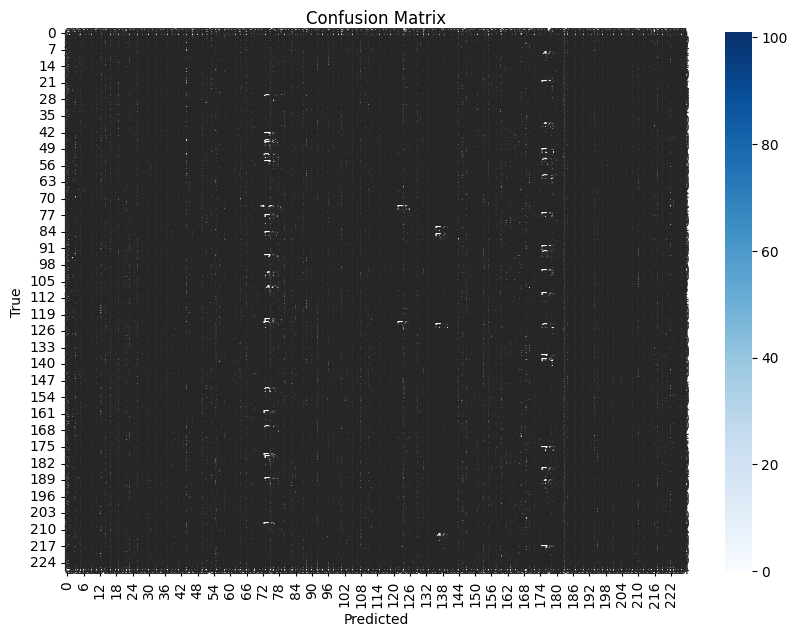

AttributeError: ignored

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convert lists to numpy arrays for compatibility with sklearn
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Ensure the class names are in the correct order for target_names
ordered_class_names = [name for name, num in sorted(dataset.sign_to_label.items(), key=lambda item: item[1])]

# Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    class_name = ordered_class_names[i]
    print(f"Accuracy for class {i} ({class_name}): {acc*100:.2f}%")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=1))

In [ ]:
from sklearn.metrics import classification_report

def print_top_misclassified_classes(y_true, y_pred, sign_to_label, N=3, zero_division=1):
    """
    Prints the top N classes that get misclassified the most.

    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels by the model
    - sign_to_label: Dictionary mapping class names to class numbers
    - N: Number of top misclassified classes to print
    - zero_division: Parameter for handling zero division in classification_report

    Returns:
    None
    """

    # Ensure the class names are in the correct order for target_names
    ordered_class_names = [name for name, num in sorted(sign_to_label.items(), key=lambda item: item[1])]

    # Generate and print classification report with class names
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=zero_division))

    # Generate classification report as dict to find misclassified classes
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=zero_division)

    # Create a dictionary to store misclassification rates
    misclassification_rates = {}

    # Iterate through each class in the report
    for class_num, metrics in report.items():
        if class_num.isdigit():
            class_name = [key for key, value in sign_to_label.items() if value == int(class_num)][0]
            misclassification_rates[class_name] = 1 - metrics['recall']

    # Sort classes based on misclassification rate
    sorted_classes = sorted(misclassification_rates, key=misclassification_rates.get, reverse=True)

    # Print top N misclassified classes
    print(f"\nTop {N} misclassified classes:")
    for i in range(N):
        class_name = sorted_classes[i]
        print(f"{i+1}. {class_name} - Misclassification rate: {misclassification_rates[class_name]:.2f}")

In [ ]:
print_top_misclassified_classes(y_true, y_pred, dataset.sign_to_label, N=10, zero_division=1)